In [1]:
import numpy as np
import pandas as pd
import datetime

from datascience import *
from datetime import timedelta
from datetime import date
from datetime import datetime

%matplotlib inline
import matplotlib.pyplot as plots
plots.style.use('fivethirtyeight')

import locale

In [2]:
# Import CSV
csv_directory = "data/csv/"

all_sales_data = Table.read_table(csv_directory+'manhattan.csv', low_memory=False)


In [3]:
# remove and sales less than $100 they are strange


all_sales_data = all_sales_data.where('SALE PRICE', are.above(100000))

In [4]:
# SPOT CHECK: Understand the data lables we might be interested in
all_sales_data.sort("SALE PRICE").show(20)
all_sales_data.labels

Unnamed: 0,ADDRESS,APARTMENT NUMBER,BLOCK,BOROUGH,BUILDING CLASS AS OF FINAL ROLL 17/18,BUILDING CLASS AT PRESENT,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,COMMERCIAL UNITS,EASE-MENT,GROSS SQUARE FEET,LAND SQUARE FEET,LOT,NEIGHBORHOOD,RESIDENTIAL UNITS,SALE DATE,SALE PRICE,TAX CLASS AS OF FINAL ROLL 17/18,TAX CLASS AT PRESENT,TAX CLASS AT TIME OF SALE,TOTAL UNITS,YEAR BUILT,ZIP CODE
9562,102 WEST 57TH STREET,,1009,1,nan,H2,H2,25 LUXURY HOTELS,2,,112850,7532,37,MIDTOWN WEST,0,2011-10-19,100009,nan,4,4,2,2007,10019
10168,102 WEST 57TH STREET,,1009,1,nan,H2,H2,25 LUXURY HOTELS,2,,112850,7532,37,MIDTOWN WEST,0,2011-07-27,100009,nan,4,4,2,2007,10019
10547,90 LA SALLE ST,,1978,1,nan,D4,D4,10 COOPS - ELEVATOR APARTMENTS,0,,0,0,1,MORNINGSIDE HEIGHTS,0,2003-12-05,100033,nan,2,2,0,1956,10027
371,"365 WEST 25TH STREET, 14F",,749,1,nan,D4,D4,10 COOPS - ELEVATOR APARTMENTS,0,,0,0,1,CHELSEA,0,2016-08-01,100042,nan,2,2,0,1963,10001
372,"365 WEST 25TH STREET, 4A",,749,1,nan,D4,D4,10 COOPS - ELEVATOR APARTMENTS,0,,0,0,1,CHELSEA,0,2016-08-01,100042,nan,2,2,0,1963,10001
401,"345 8TH AVENUE, 3A",,751,1,nan,D4,D4,10 COOPS - ELEVATOR APARTMENTS,0,,0,0,1,CHELSEA,0,2016-08-01,100042,nan,2,2,0,1960,10001
12025,102 WEST 57TH STREET,,1009,1,nan,H2,H2,25 LUXURY HOTELS,2,,112850,7532,37,MIDTOWN WEST,0,2013-05-14,100060,nan,4,4,2,2007,10019
11787,102 WEST 57TH STREET,,1009,1,nan,H2,H2,25 LUXURY HOTELS,2,,112850,7532,37,MIDTOWN WEST,0,2013-07-02,100100,nan,4,4,2,2007,10019
11920,102 WEST 57TH STREET,,1009,1,nan,H2,H2,25 LUXURY HOTELS,2,,112850,7532,37,MIDTOWN WEST,0,2013-06-05,100100,nan,4,4,2,2007,10019
12277,102 WEST 57TH ST,,1009,1,nan,H2,H2,25 LUXURY HOTELS,2,,112850,7532,37,MIDTOWN WEST,0,2013-03-05,100100,nan,4,4,2,2007,10019


('Unnamed: 0',
 'ADDRESS',
 'APARTMENT NUMBER',
 'BLOCK',
 'BOROUGH',
 'BUILDING CLASS AS OF FINAL ROLL 17/18',
 'BUILDING CLASS AT PRESENT',
 'BUILDING CLASS AT TIME OF SALE',
 'BUILDING CLASS CATEGORY',
 'COMMERCIAL UNITS',
 'EASE-MENT',
 'GROSS SQUARE FEET',
 'LAND SQUARE FEET',
 'LOT',
 'NEIGHBORHOOD',
 'RESIDENTIAL UNITS',
 'SALE DATE',
 'SALE PRICE',
 'TAX CLASS AS OF FINAL ROLL 17/18',
 'TAX CLASS AT PRESENT',
 'TAX CLASS AT TIME OF SALE',
 'TOTAL UNITS',
 'YEAR BUILT',
 'ZIP CODE')

In [5]:
# Remove redundant cells

all_sales_data = all_sales_data.select(['SALE DATE', 'SALE PRICE', 'ADDRESS','APARTMENT NUMBER', 'YEAR BUILT', 'NEIGHBORHOOD', 'ZIP CODE', 'BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY'])

In [6]:
# Combine the Address and Apt No

def combine_address(address, aptNo):
    """Combine the address and Apartment into a single result"""
    temp = address.strip()
    if len(aptNo.strip()) > 0:
        temp = temp + ', ' + aptNo.strip()
    return temp

full_address = all_sales_data.apply(combine_address, ['ADDRESS', 'APARTMENT NUMBER'])

/usr/local/lib/python3.6/site-packages/datascience/tables.py:361: FutureWarning: column lists are deprecated; pass each as an argument
  "column lists are deprecated; pass each as an argument", FutureWarning)


In [7]:
# Add a Full Address column
all_sales_data =  all_sales_data.with_column('FULL ADDRESS', full_address)

In [8]:
# Try to understand Building Class Codes. Whare the most common Codes
all_sales_data.group(['BUILDING CLASS AT TIME OF SALE', 'BUILDING CLASS CATEGORY']).sort('count', descending=True).show(20)

# Question what's R5 -  COMMERCIAL CONDOS? ignoring for now

BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,count
R4,13 CONDOS - ELEVATOR APARTMENTS,89835
D4,10 COOPS - ELEVATOR APARTMENTS,82040
R9,17 CONDOPS,9942
C6,09 COOPS - WALKUP APARTMENTS,9928
R4,13 CONDOS - ELEVATOR APARTMENTS,5852
D4,10 COOPS - ELEVATOR APARTMENTS,5286
R9,17 CONDO COOPS,4088
D0,10 COOPS - ELEVATOR APARTMENTS,3296
R1,15 CONDOS - 2-10 UNIT RESIDENTIAL,3247
R5,28 COMMERCIAL CONDOS,3228


In [9]:
# Let's pick out the condos for now. 
# See ## for condo codes
condos = all_sales_data.where('BUILDING CLASS AT TIME OF SALE', are.contained_in("R1R2R3R4R6"))

In [10]:
# Spot Check condo data
condos.sample(10)

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2011-07-01,993228,382 CENTRAL PARK WEST,14C,1961,MANHATTAN VALLEY,10025,R4,13 CONDOS - ELEVATOR APARTMENTS,"382 CENTRAL PARK WEST, 14C"
2008-02-13,2468893,250 EAST 53RD STREET,1404,2006,MIDTOWN EAST,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"250 EAST 53RD STREET, 1404"
2005-04-07,783000,170 EAST 87TH STREET,E7H,0,UPPER EAST SIDE (79-96),10128,R4,13 CONDOS - ELEVATOR APARTMENTS,"170 EAST 87TH STREET, E7H"
2015-08-17,460000,113 ELDRIDGE STREET,2B,0,LOWER EAST SIDE,10002,R4,13 CONDOS - ELEVATOR APARTMENTS,"113 ELDRIDGE STREET, 2B"
2013-07-26,2825000,50 WEST 15TH STREET,4D,2008,FLATIRON,10011,R4,13 CONDOS - ELEVATOR APARTMENTS,"50 WEST 15TH STREET, 4D"
2017-08-09,1235000,635 WEST 42ND STREET,9G,2005,CLINTON,10036,R4,13 CONDOS - ELEVATOR APARTMENTS,"635 WEST 42ND STREET, 9G"
2004-02-11,572766,333 EAST 34 STREET,10M,1961,KIPS BAY,10016,R4,13 CONDOS - ELEVATOR APARTMENTS,"333 EAST 34 STREET, 10M"
2010-05-05,1272812,250 EAST 65TH STREET,14F,1963,UPPER EAST SIDE (59-79),10065,R4,13 CONDOS - ELEVATOR APARTMENTS,"250 EAST 65TH STREET, 14F"
2013-01-24,895000,333 RECTOR PLACE,PH3S,1985,TRIBECA,10280,R4,13 CONDOS - ELEVATOR APARTMENTS,"333 RECTOR PLACE, PH3S"
2005-05-26,1680000,106 WAVERLY PLACE,1,0,GREENWICH VILLAGE-CENTRAL,10011,R1,15 CONDOS - 2-10 UNIT RESIDENTIAL,"106 WAVERLY PLACE, 1"


In [11]:
# Let's find condos with multiple sales

condos.group('FULL ADDRESS').sort(1, descending=True).show(30)

# Looks like Apt numbers are missing for most of the top sales. let's ignore anything without an apt number. 

FULL ADDRESS,count
1 WEST END AVENUE,136
45 EAST 22ND STREET,51
245 WEST 99TH STREET,49
171 WEST 131 STREET,44
959 1 AVENUE,42
416 WEST 52ND STREET,39
245 WEST 99TH STREET,37
2094 FREDRICK DOUGLASS BL,35
172 MADISON AVENUE,35
360 EAST 89TH STREET,23


In [12]:
# Find condos with apt numbers i.e. clean data, then find those with more that 1 sale record.

multi_sale_condos = condos.where('FULL ADDRESS', are.containing(',')).group('FULL ADDRESS').sort(1, descending=True).where('count', are.above(1))
multi_sale_condos

#ahh much better, fewer sales but still roughly 15K records

FULL ADDRESS,count
"2 EAST 55 STREET, 835",8
"2 EAST 55TH STREET, 935",7
"2 EAST 55 STREET, 921",7
"77 PARK AVENUE, 2F",6
"418 CENTRAL PARK WEST, 22",6
"2 EAST 55 STREET, 936",6
"2 EAST 55 STREET, 903",6
"15 BROAD STREET, 2116",6
"140 7 AVENUE, 6A",6
"52 PARK AVENUE, 7",5


In [13]:
# Define condos with multiple sales. 

multi_sale_condos = multi_sale_condos.join('FULL ADDRESS', condos, 'FULL ADDRESS')
multi_sale_condos.sort(0)

FULL ADDRESS,count,SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY
"1 BOND STREET, 2C",2,2017-08-18,5640000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2C",2,2010-12-15,600000,1 BOND STREET,2C,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2009-04-24,1195000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 2D",2,2014-01-07,1925000,1 BOND STREET,2D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2013-06-14,7200000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 3A",2,2008-06-06,5030000,1 BOND STREET,3A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2006-08-30,1565000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 4D",2,2013-08-20,2415000,1 BOND STREET,4D,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 6A",2,2012-12-12,3600000,1 BOND STREET,6A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS
"1 BOND STREET, 6A",2,2017-09-06,5250000,1 BOND STREET,6A,0,GREENWICH VILLAGE-CENTRAL,10012,R4,13 CONDOS - ELEVATOR APARTMENTS


In [14]:
# Find the first and last Sale Dates

first_sale_dates = multi_sale_condos.select(0, 2).group([0], min)
last_sale_dates = multi_sale_condos.select(0, 2).group([0], max)

# Spot check data
first_sale_dates.show(5)
last_sale_dates.show(5)

FULL ADDRESS,SALE DATE min
"1 BOND STREET, 2C",2010-12-15
"1 BOND STREET, 2D",2009-04-24
"1 BOND STREET, 3A",2008-06-06
"1 BOND STREET, 4D",2006-08-30
"1 BOND STREET, 6A",2012-12-12


FULL ADDRESS,SALE DATE max
"1 BOND STREET, 2C",2017-08-18
"1 BOND STREET, 2D",2014-01-07
"1 BOND STREET, 3A",2013-06-14
"1 BOND STREET, 4D",2013-08-20
"1 BOND STREET, 6A",2017-09-06


In [15]:
# Update Labels

first_sale_dates = first_sale_dates.relabel(1, 'FIRST SALE')
last_sale_dates = last_sale_dates.relabel(1, 'LAST SALE')

In [16]:
# Join with Condos to get the sale price
first_sale_dates = first_sale_dates.join("FULL ADDRESS", condos, 'FULL ADDRESS').where('SALE DATE', are.equal_to, 'FIRST SALE')
first_sale_dates = first_sale_dates.select('FULL ADDRESS', 'FIRST SALE', 'SALE PRICE')


last_sale_dates = last_sale_dates.join("FULL ADDRESS", condos, 'FULL ADDRESS').where('SALE DATE', are.equal_to, 'LAST SALE')
last_sale_dates = last_sale_dates.select('FULL ADDRESS', 'LAST SALE', 'SALE PRICE')

In [17]:
first_sale_dates.show(5)
last_sale_dates.show(5)

# Hmm earlier we had 14730 now we have more and they don't match. Could we have duplicates??

FULL ADDRESS,FIRST SALE,SALE PRICE
"1 BOND STREET, 2C",2010-12-15,600000
"1 BOND STREET, 2D",2009-04-24,1195000
"1 BOND STREET, 3A",2008-06-06,5030000
"1 BOND STREET, 4D",2006-08-30,1565000
"1 BOND STREET, 6A",2012-12-12,3600000


FULL ADDRESS,LAST SALE,SALE PRICE
"1 BOND STREET, 2C",2017-08-18,5640000
"1 BOND STREET, 2D",2014-01-07,1925000
"1 BOND STREET, 3A",2013-06-14,7200000
"1 BOND STREET, 4D",2013-08-20,2415000
"1 BOND STREET, 6A",2017-09-06,5250000


In [18]:
# Yep duplicate sales on the same day wtf!

first_sale_dates.groups([0,1]).sort(2, descending=True)

FULL ADDRESS,FIRST SALE,count
"2 EAST 55 STREET, 921",2006-08-22,4
"201 WEST 17TH STREET, 7A",2014-03-31,3
"131 BANK ST, 4",2004-07-01,3
"99 JOHN STREET, 423",2013-11-21,2
"949 PARK AVENUE, PH",2012-01-31,2
"93 WORTH STREET, PH1",2016-03-03,2
"93 WORTH STREET, 301",2014-04-03,2
"88 FRANKLIN STREET, 2",2012-12-21,2
"845 UNITED NATIONS PLAZA, 43D",2006-09-15,2
"845 UNITED NATIONS PLAZA, 32B",2005-07-06,2


In [19]:
condos.where('FULL ADDRESS', are.equal_to('2 EAST 55 STREET, 921')).show()
first_sale_dates.where('FULL ADDRESS', are.containing('201 WEST 17TH'))

SALE DATE,SALE PRICE,ADDRESS,APARTMENT NUMBER,YEAR BUILT,NEIGHBORHOOD,ZIP CODE,BUILDING CLASS AT TIME OF SALE,BUILDING CLASS CATEGORY,FULL ADDRESS
2006-10-09,467251,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-10-09,403977,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-09-05,451230,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22,486720,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22,496860,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22,486922,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"
2006-08-22,412393,2 EAST 55 STREET,921,1903,MIDTOWN CBD,10022,R4,13 CONDOS - ELEVATOR APARTMENTS,"2 EAST 55 STREET, 921"


FULL ADDRESS,FIRST SALE,SALE PRICE
"201 WEST 17TH STREET, 7A",2014-03-31,999652
"201 WEST 17TH STREET, 7A",2014-03-31,999652
"201 WEST 17TH STREET, 7A",2014-03-31,999652


In [20]:
# ok let's just take the corresponding min and max value to keep moving

first_sale_dates = first_sale_dates.group([0,1], min)
last_sale_dates = last_sale_dates.group([0,1], max)

In [21]:
# Relabel and join the 2 tables to create condo sales
first_sale_dates = first_sale_dates.relabel(2, 'FIRST PRICE')
last_sale_dates = last_sale_dates.relabel(2, 'LAST PRICE')


condo_sales = first_sale_dates.join('FULL ADDRESS', last_sale_dates, 'FULL ADDRESS')
condo_sales

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE
"1 BOND STREET, 2C",2010-12-15,600000,2017-08-18,5640000
"1 BOND STREET, 2D",2009-04-24,1195000,2014-01-07,1925000
"1 BOND STREET, 3A",2008-06-06,5030000,2013-06-14,7200000
"1 BOND STREET, 4D",2006-08-30,1565000,2013-08-20,2415000
"1 BOND STREET, 6A",2012-12-12,3600000,2017-09-06,5250000
"1 BOND STREET, 6B",2004-12-01,2996000,2016-05-20,4350000
"1 CENTRAL PARK SOUTH, 503",2012-12-18,7995000,2017-02-24,10150000
"1 CENTRAL PARK WEST, 23B",2008-04-03,5580000,2012-06-28,6200000
"1 CENTRAL PARK WEST, 24A",2004-08-06,2575000,2016-03-28,9636000
"1 CENTRAL PARK WEST, 25A",2004-07-13,4700000,2009-10-08,5925000


In [22]:
# Set the date format for sale date

condo_sales = condo_sales.set_format('FIRST SALE', DateFormatter('%Y-%m-%d')).set_format('LAST SALE', DateFormatter('%Y-%m-%d'))


# condo_sales.select('FIRST SALE').apply(lambda str: datetime.strptime(str, '%Y-%m-%d'))


In [23]:
# Calculate Price Diffs

price_diffs = condo_sales.column('LAST PRICE') - condo_sales.column('FIRST PRICE')
date_diffs = condo_sales.column('LAST SALE') - condo_sales.column('FIRST SALE')

condo_sales = condo_sales.with_column( "PRICE CHANGE", price_diffs, "PERIOD", date_diffs)
condo_sales.set_format('PRICE CHANGE', NumberFormatter())

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"1 BOND STREET, 2C",2010-12-15,600000,2017-08-18,5640000,"5,040,000",2.1064e+08
"1 BOND STREET, 2D",2009-04-24,1195000,2014-01-07,1925000,"730,000",1.48525e+08
"1 BOND STREET, 3A",2008-06-06,5030000,2013-06-14,7200000,"2,170,000",1.58458e+08
"1 BOND STREET, 4D",2006-08-30,1565000,2013-08-20,2415000,"850,000",2.20061e+08
"1 BOND STREET, 6A",2012-12-12,3600000,2017-09-06,5250000,"1,650,000",1.49382e+08
"1 BOND STREET, 6B",2004-12-01,2996000,2016-05-20,4350000,"1,354,000",3.6184e+08
"1 CENTRAL PARK SOUTH, 503",2012-12-18,7995000,2017-02-24,10150000,"2,155,000",1.32106e+08
"1 CENTRAL PARK WEST, 23B",2008-04-03,5580000,2012-06-28,6200000,"620,000",1.33661e+08
"1 CENTRAL PARK WEST, 24A",2004-08-06,2575000,2016-03-28,9636000,"7,061,000",3.67373e+08
"1 CENTRAL PARK WEST, 25A",2004-07-13,4700000,2009-10-08,5925000,"1,225,000",1.65283e+08


In [24]:
# Understand price difference data
def column_stats( data ):
    '''Prints common stats for a data array'''
    data_mean = np.mean(data)
    data_std = np.std(data)
    data_min = min(data)
    data_max = max(data)

    percent_5 = percentile(5, data)
    percent_95 = percentile(95, data)
    percent_1 = percentile(1, data)
    percent_99 = percentile(99, data)

    print("Avg:", data_mean, "\nStd:", data_std, "\nMin:", data_min, "\nMax:", data_max)
    print(" 5%:", percent_5, "\n95%:", percent_95)
    print(" 1%:", percent_1, "\n99%:", percent_99)


column_stats(price_diffs)



Avg: 394695.1946914953 
Std: 2640779.292865033 
Min: -183014844 
Max: 44312249
 5%: -164400 
95%: 1895000
 1%: -1506025 
99%: 5270000


FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"15 WILLIAM STREET, 3M",2010-12-01,184414937,2011-12-22,1400093,"-183,014,844",3.33504e+07
"421 HUDSON STREET, 201",2012-01-18,67602825,2014-07-14,1750000,"-65,852,825",7.84476e+07
"322 WEST 57TH STREET, 15B1",2009-08-06,53268315,2011-10-13,1934675,"-51,333,640",6.89472e+07
"25 MURRAY STREET, LLA",2008-05-07,40000000,2008-08-13,304200,"-39,695,800",8.4672e+06
"25 MURRAY STREET, 2D",2008-06-17,32800000,2008-07-23,1349181,"-31,450,819",3.1104e+06
"203 WEST 90 STREET, 7C",2003-01-24,32000000,2003-03-13,648310,"-31,351,690",4.1472e+06
"220 EAST 65 STREET, 2K",2004-03-11,25750000,2004-05-06,393432,"-25,356,568",4.8348e+06
"220 EAST 65 STREET, 7D",2004-03-11,25750000,2004-11-08,395460,"-25,354,540",2.09088e+07
"220 EAST 65 STREET, 3A/B",2004-03-11,25750000,2004-04-15,415740,"-25,334,260",3.0204e+06
"220 EAST 65 STREET, 2N",2004-03-11,25750000,2004-06-15,420810,"-25,329,190",8.2908e+06


/usr/local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


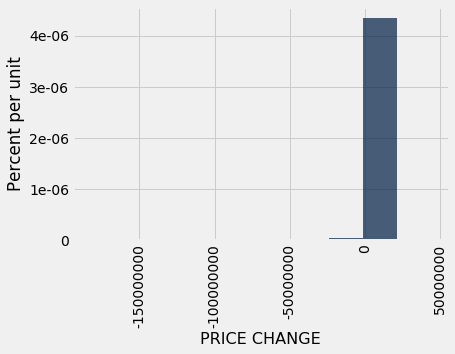

In [25]:
condo_sales.sort('PRICE CHANGE').show(20)

condo_sales.select('PRICE CHANGE').hist()

In [26]:
# strip out the outliers for now. 
percent_1 = percentile(1, price_diffs)
percent_99 = percentile(99, price_diffs)

condo_sales = condo_sales.where('PRICE CHANGE', are.between(percent_1, percent_99))


In [27]:
# understand the Price stats with the outliers removed. 

column_stats(price_diffs)

print("------")

column_stats(condo_sales.column('PRICE CHANGE'))

Avg: 394695.1946914953 
Std: 2640779.292865033 
Min: -183014844 
Max: 44312249
 5%: -164400 
95%: 1895000
 1%: -1506025 
99%: 5270000
------
Avg: 438677.10067352 
Std: 681500.2493369791 
Min: -1506025 
Max: 5252900
 5%: -125112 
95%: 1704738
 1%: -593800 
99%: 3465138


In [28]:
# look into period Calcs

condo_sales
# print(timedelta(seconds=condo_sales.column('PERIOD')[0]).days)

# condo_sales.take(1)

FULL ADDRESS,FIRST SALE,FIRST PRICE,LAST SALE,LAST PRICE,PRICE CHANGE,PERIOD
"1 BOND STREET, 2C",2010-12-15,600000,2017-08-18,5640000,"5,040,000",2.1064e+08
"1 BOND STREET, 2D",2009-04-24,1195000,2014-01-07,1925000,"730,000",1.48525e+08
"1 BOND STREET, 3A",2008-06-06,5030000,2013-06-14,7200000,"2,170,000",1.58458e+08
"1 BOND STREET, 4D",2006-08-30,1565000,2013-08-20,2415000,"850,000",2.20061e+08
"1 BOND STREET, 6A",2012-12-12,3600000,2017-09-06,5250000,"1,650,000",1.49382e+08
"1 BOND STREET, 6B",2004-12-01,2996000,2016-05-20,4350000,"1,354,000",3.6184e+08
"1 CENTRAL PARK SOUTH, 503",2012-12-18,7995000,2017-02-24,10150000,"2,155,000",1.32106e+08
"1 CENTRAL PARK WEST, 23B",2008-04-03,5580000,2012-06-28,6200000,"620,000",1.33661e+08
"1 CENTRAL PARK WEST, 25A",2004-07-13,4700000,2009-10-08,5925000,"1,225,000",1.65283e+08
"1 CENTRAL PARK WEST, 25F",2006-02-15,2000000,2007-06-19,2650000,"650,000",4.2246e+07


In [29]:
# condo_sales.sample(100).scatter('FIRST SALE', 'FIRST PRICE')
dates = [datetime.strptime('%Y-%m-%d', d) for d in condo_sales.column('FIRST SALE')]
dates

# condo_sales.apply

AttributeError: module 'datetime' has no attribute 'strptime'